In [117]:
import pandas as pd
import numpy as np

# Load the catalog data
file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/PhD_Monash/Paper2/time-series/data/SUeq_data.csv'
catalog = pd.read_csv(file_path)

catalog_SUM = catalog[(catalog['LAT'] < 15) & (catalog['LAT'] >= -1) 
                      & (catalog['MW'] >= 6.0) & (catalog['CLASS'] != 'UPPER')]

catalog_SUM_mthrust = catalog[(catalog['LAT'] < 15) & (catalog['LAT'] >= -1) 
                      & (catalog['MW'] >= 6.0) & (catalog['CLASS'] == 'MTHRUST')]
                                                  
catalog_java_dgoing = catalog[(catalog['LAT'] < -1) & (catalog['MW'] >= 6.0) & (catalog['CLASS'] != 'UPPER')]
# catalog_java_dgoing = catalog[(catalog['LAT'] < -1) & (catalog['MW'] >= 6.0) & (catalog['CLASS'] == 'DGOING')]

# Concatenate catalog_SUM_mthrust and catalog_java_dgoing vertically
catalog_java = pd.concat([catalog_SUM_mthrust, catalog_java_dgoing], axis=0).reset_index(drop=True)

# Display the first few rows of the dataset to understand its structure
# catalog.head()

/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_70500/187435308.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  catalog_SUM['DATETIME'] = pd.to_datetime(catalog_SUM['DATE'] + ' ' + catalog_SUM['TIME'], errors='coerce')
/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_70500/187435308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_SUM['DATETIME'] = pd.to_datetime(catalog_SUM['DATE'] + ' ' + catalog_SUM['TIME'], errors='coerce')


Number of events read after filtering: 27


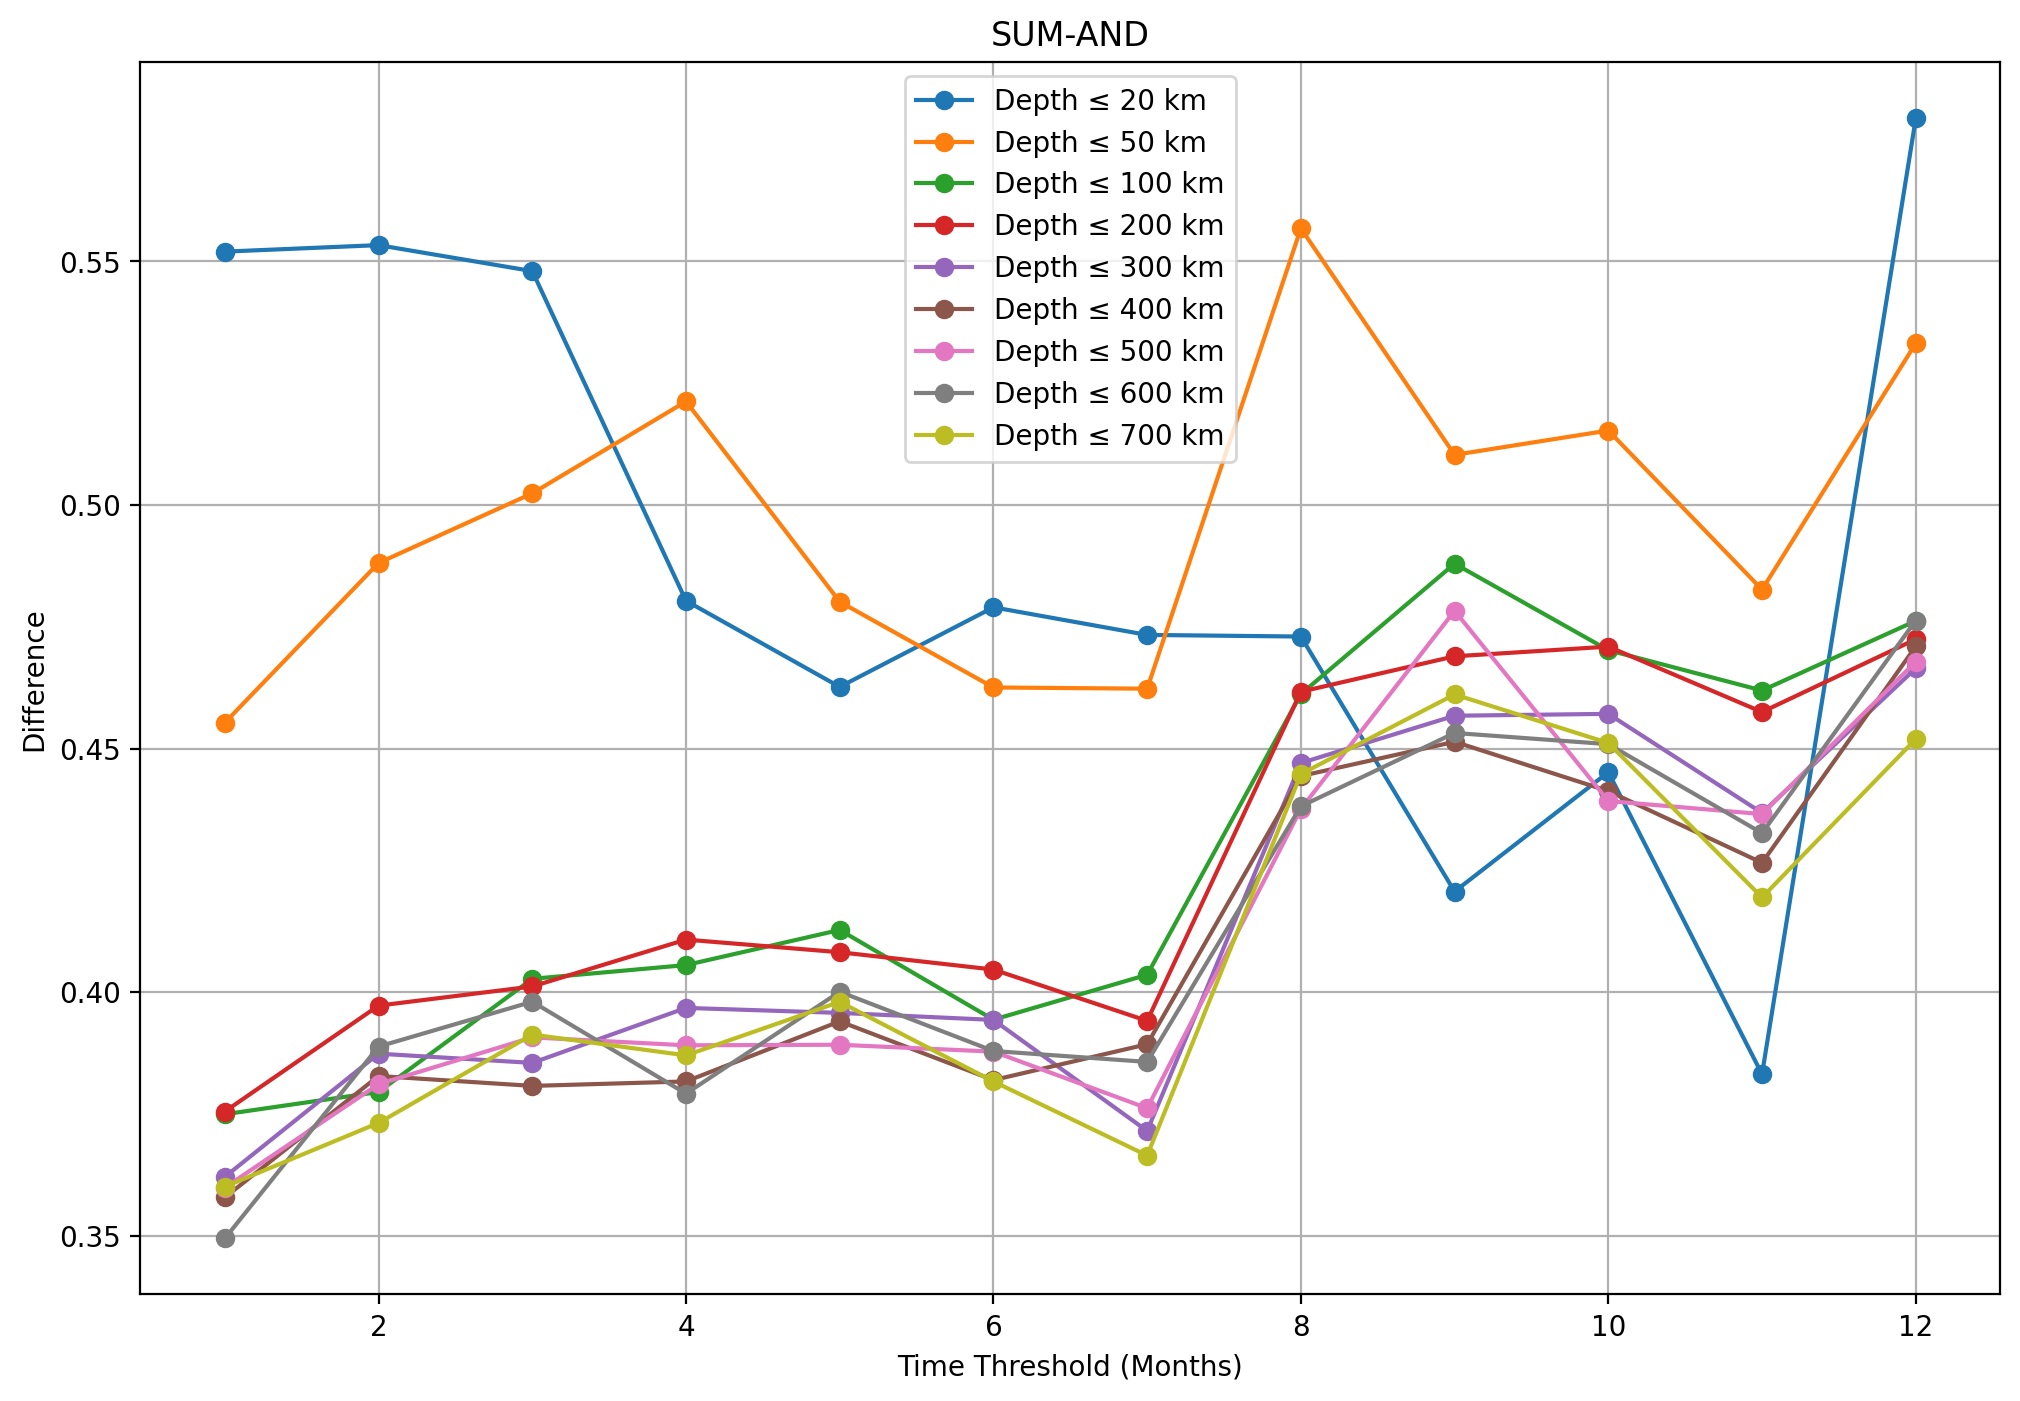

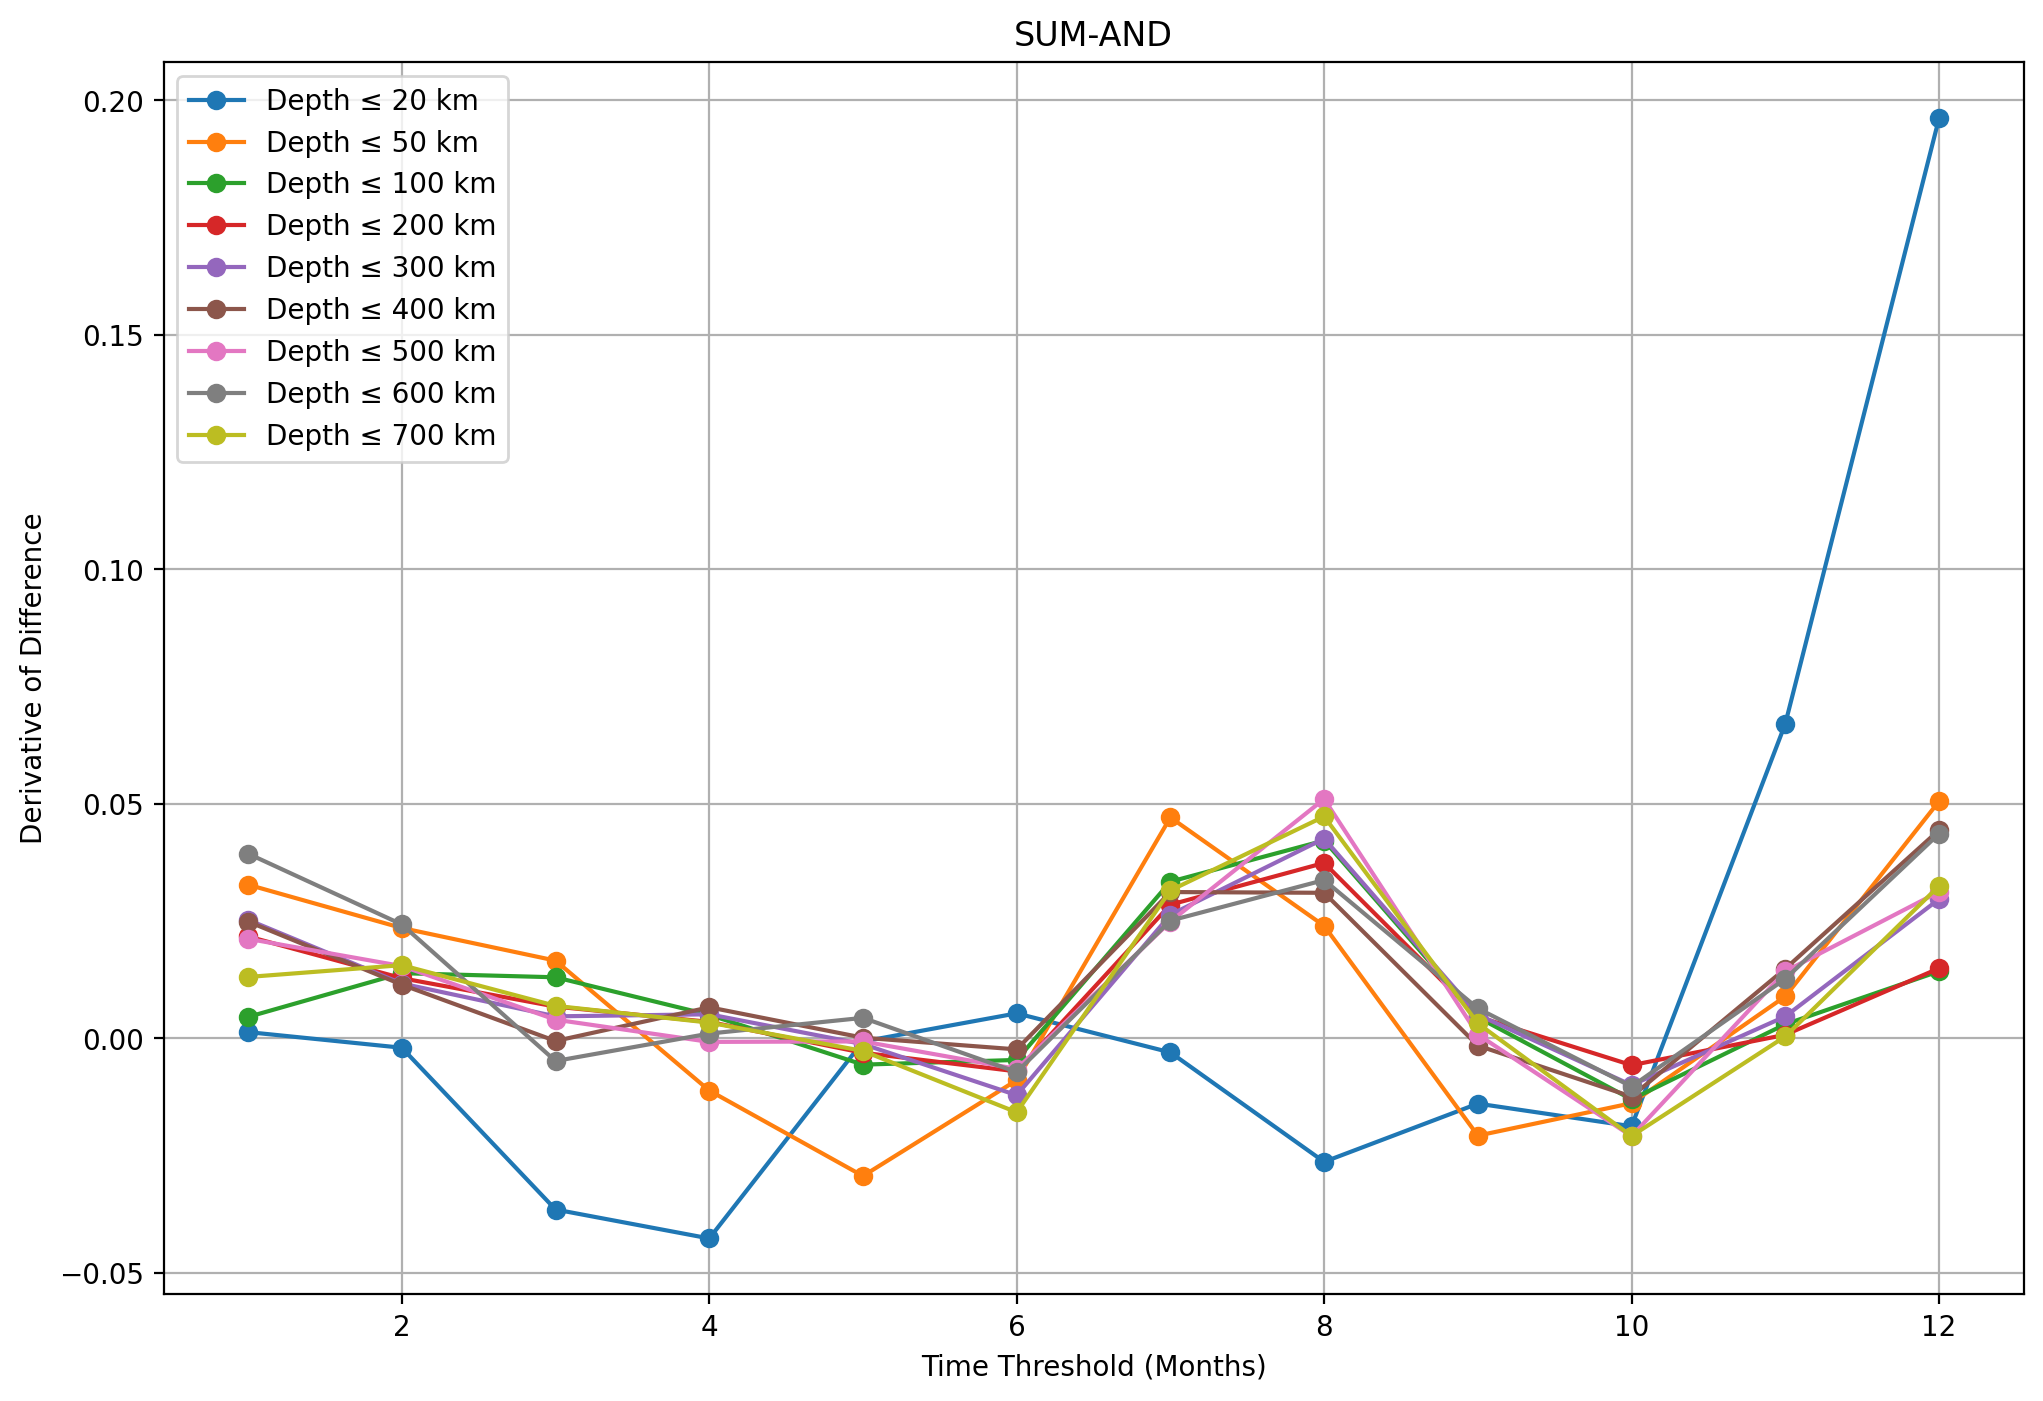

In [118]:
# Extract relevant columns: time (assuming 'DATE' and 'TIME' columns) and depth ('DEPTH')
catalog_SUM['DATETIME'] = pd.to_datetime(catalog_SUM['DATE'] + ' ' + catalog_SUM['TIME'], errors='coerce')
catalog_SUM = catalog_SUM.sort_values('DATETIME').reset_index(drop=True)

# Initialize variables
t = np.zeros(len(catalog_SUM), dtype=np.float64)
z = np.zeros(len(catalog_SUM), dtype=np.float64)
dt = np.zeros(len(catalog_SUM) - 1, dtype=np.float64)
dts = np.zeros(len(catalog_SUM) - 1, dtype=np.float64)

# Constants
t0 = 5 * 30.5 * 24 * 3600  # 5 months in seconds
z0 = 20  # 20 km depth threshold

# Filter out rows with invalid datetime values (NaT)
catalog_SUM = catalog_SUM.dropna(subset=['DATETIME'])

# Reinitialize variables after filtering
t = catalog_SUM['DATETIME'].apply(lambda x: x.timestamp()).values  # Convert datetime to timestamp (seconds since epoch)
z = catalog_SUM['DEPTH'].values

ne = len(t) - 1
print(f"Number of events read after filtering: {ne}")

import numpy as np
import matplotlib.pyplot as plt

# Define the depth thresholds and time thresholds to test
depth_thresholds = [20, 50, 100, 200, 300, 400, 500, 600, 700]
time_thresholds = [1 * 30.5 * 24 * 3600,  # 1 month
                   2 * 30.5 * 24 * 3600,  # 2 months
                   3 * 30.5 * 24 * 3600,  # 3 months
                   4 * 30.5 * 24 * 3600,  # 4 months
                   5 * 30.5 * 24 * 3600,  # 5 months
                   6 * 30.5 * 24 * 3600,
                   7* 30.5 * 24 * 3600,  # 1 month
                   8 * 30.5 * 24 * 3600,  # 2 months
                   9 * 30.5 * 24 * 3600,  # 3 months
                   10 * 30.5 * 24 * 3600,  # 4 months
                   11 * 30.5 * 24 * 3600,  # 5 months
                   12 * 30.5 * 24 * 3600]  # 6 months

# Initialize a dictionary to store the results for each combination of depth and time thresholds
results = {}
sresults = {}    
randomized_ratios = []

# Iterate over the depth and time thresholds and perform the analysis
for z0 in depth_thresholds:
    results[z0] = {}
    sresults[z0] = {}  # Initialize the dictionary for this depth threshold

    for t0 in time_thresholds:
        # Time difference calculation
        ntot = 0
        nn = 0
        
        for i in range(ne - 1):
            dt[i] = t[i + 1] - t[i]
            if z[i] <= z0:
                if dt[i] <= t0:
                    nn +=1
                    
                ntot += 1

        # Calculate the ratio for real data
        if ntot > 0:
            real_data_ratio = nn / ntot
            results[z0][t0] = real_data_ratio  # Store the result for real data

        # Perform randomization and store the average randomized ratio
        randomized_ratios = []

        for nreal in range(100):
            nns = 0
            ntot = 0
            for i in range(ne - 1):
                tr = t[int(np.random.rand() * ne)]
                dts[i] = abs(t[i + 1] - tr)

                if dts[i] == 0:
                    continue

                if z[i] <= z0:
                    if dts[i] <= t0:
                        nns += 1
                    ntot += 1

            if ntot > 0:
                randomized_ratios.append(nns / ntot)

        average_randomized_ratio = np.mean(randomized_ratios)
        sresults[z0][t0] = average_randomized_ratio  # Store the average of the randomized ratios

# Compute the difference between the real data ratio and the computed average of the randomized ratios
differences = {}
for z0 in depth_thresholds:
    for t0 in time_thresholds:
        difference = results[z0][t0] - sresults[z0][t0]
        differences[(z0, t0)] = difference

# Prepare the data for plotting
depth_values = sorted(list(set([d[0] for d in differences.keys()])))
time_thresholds_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # in months

# Create a matrix of differences for plotting
difference_matrix_SUM = np.zeros((len(depth_values), len(time_thresholds_months)))

for i, depth in enumerate(depth_values):
    for j, t_month in enumerate(time_thresholds_months):
        t_seconds = t_month * 30.5 * 24 * 3600  # Convert months to seconds
        difference_matrix_SUM[i, j] = differences[(depth, t_seconds)]

# Plotting the differences
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, difference_matrix_SUM[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

# plt.title('Java')
plt.title('SUM-AND')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the derivative of the difference_matrix_SUM with respect to time thresholds
derivative_matrix_SUM = np.zeros_like(difference_matrix_SUM)

for i in range(difference_matrix_SUM.shape[0]):
    derivative_matrix_SUM[i, :] = np.gradient(difference_matrix_SUM[i, :], time_thresholds_months)

# Plotting the derivative of the differences
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, derivative_matrix_SUM[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

plt.title('SUM-AND')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('Derivative of Difference')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_70500/952584087.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  catalog_java['DATETIME'] = pd.to_datetime(catalog_java['DATE'] + ' ' + catalog_java['TIME'], errors='coerce')


Number of events read after filtering: 74


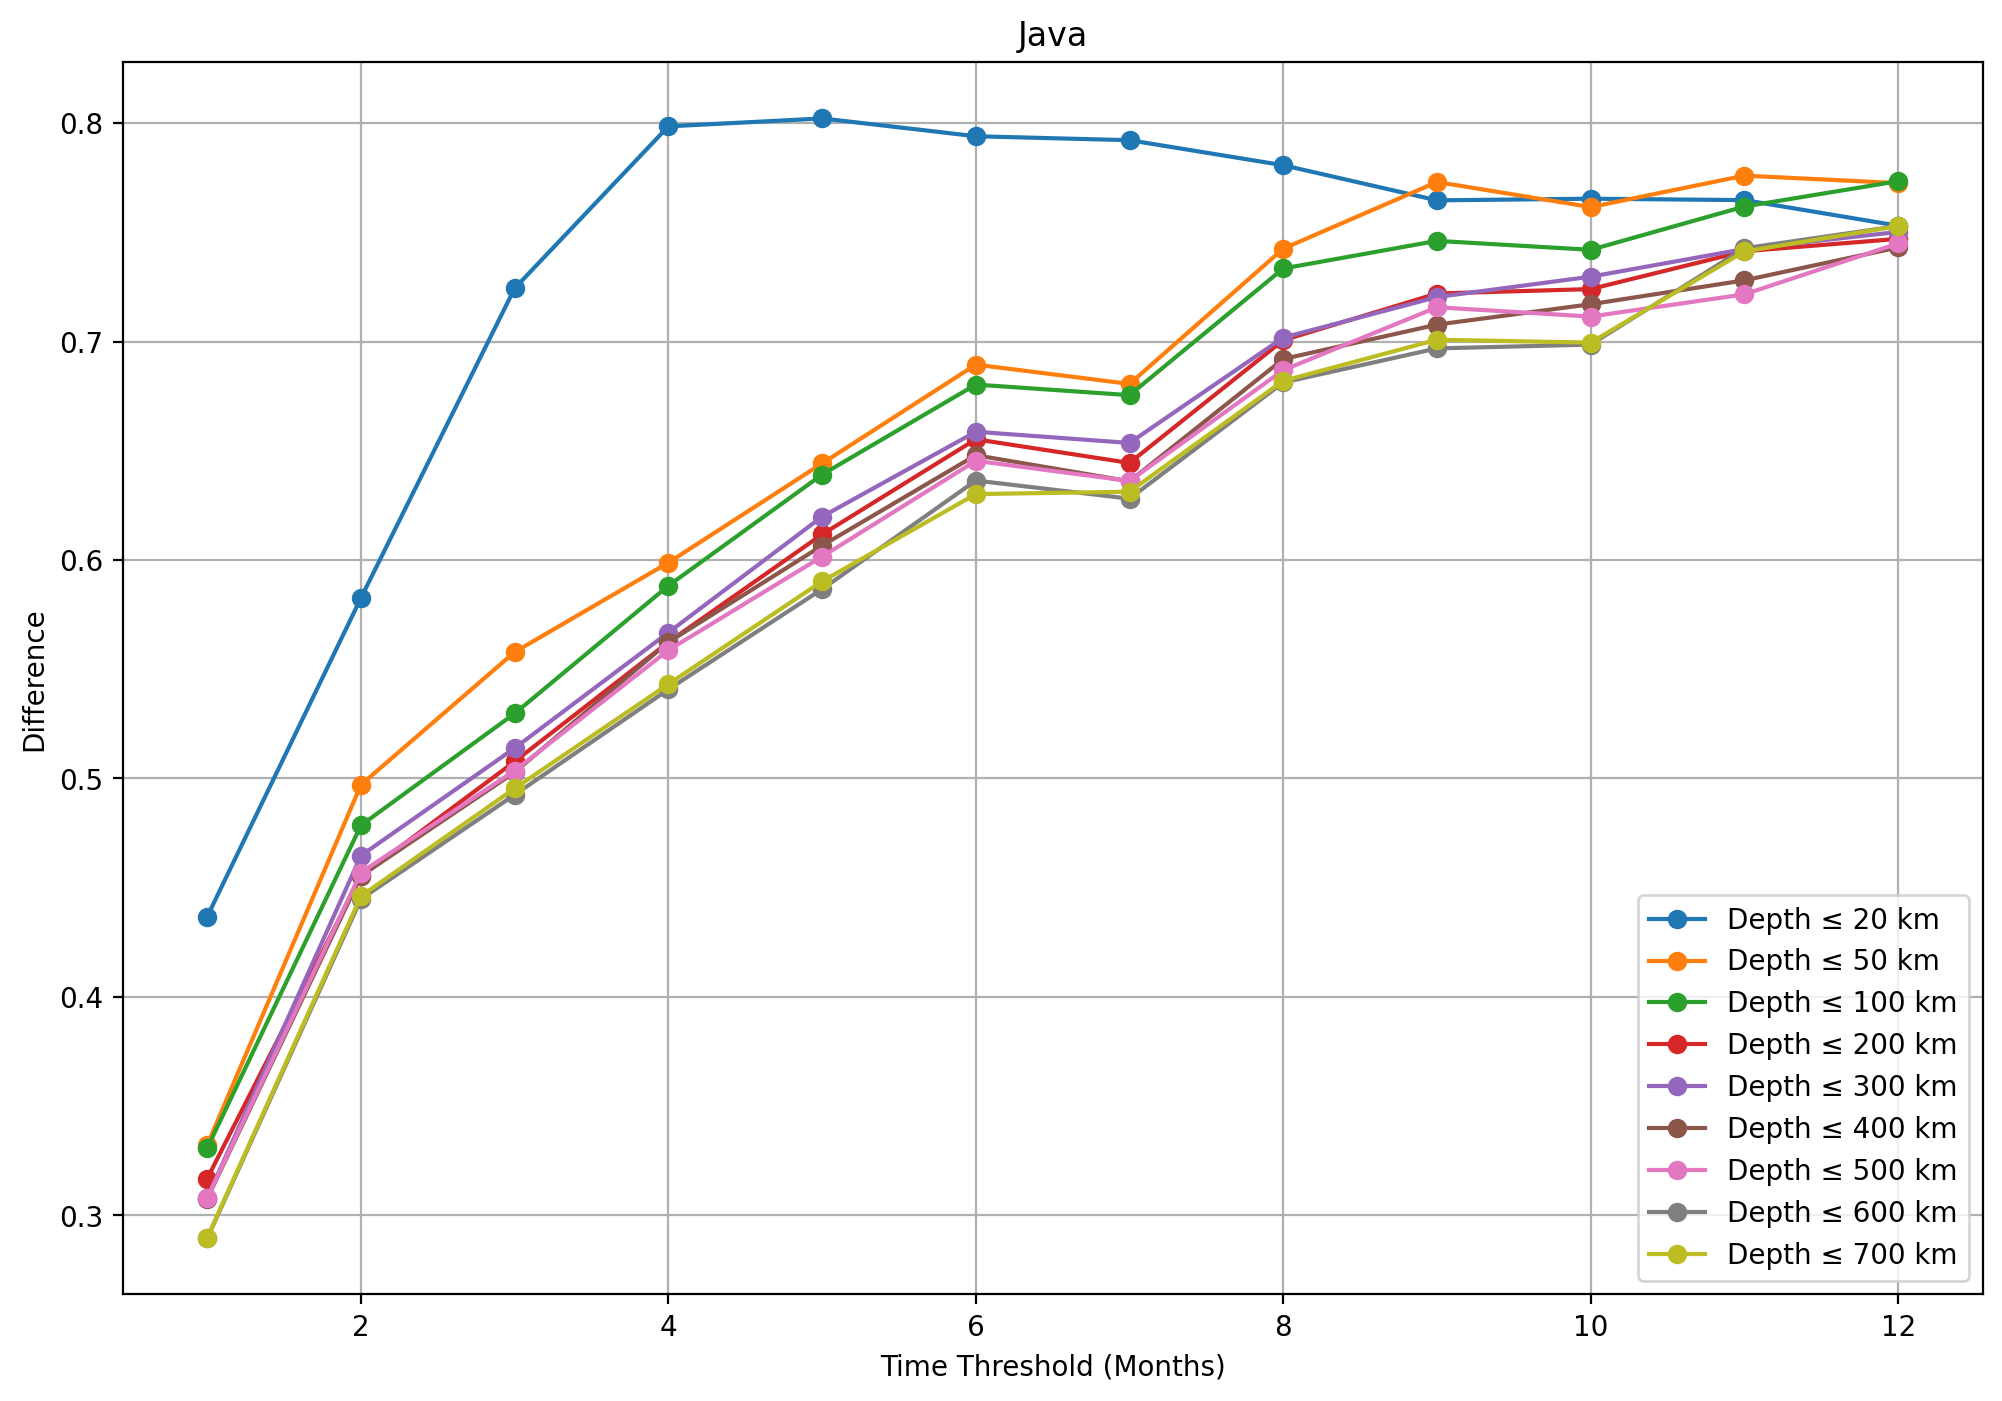

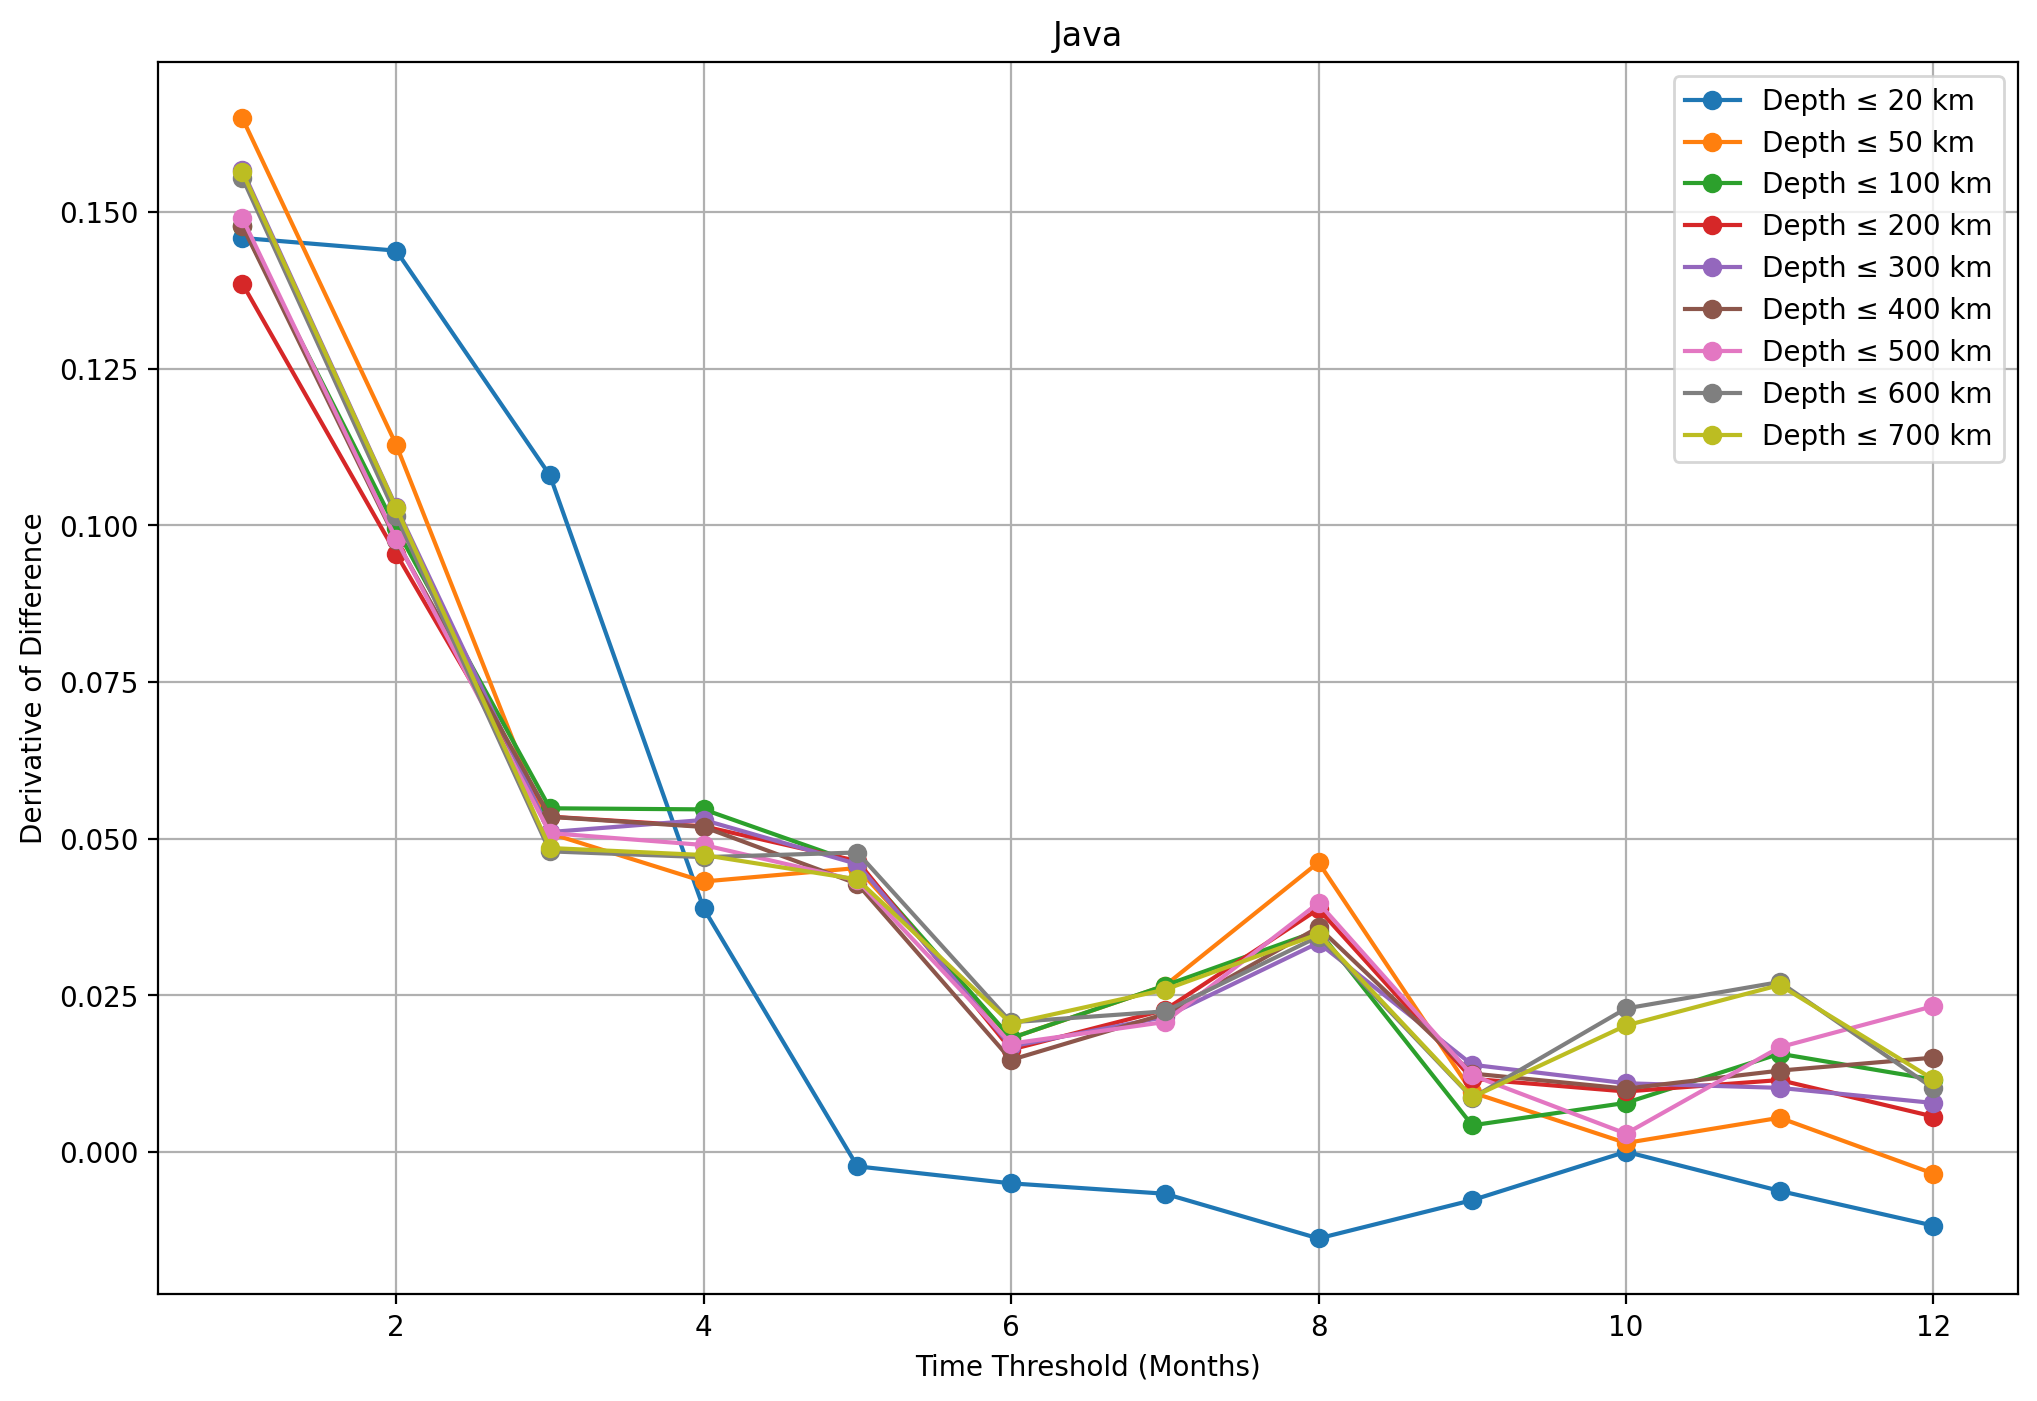

In [119]:
# Extract relevant columns: time (assuming 'DATE' and 'TIME' columns) and depth ('DEPTH')
catalog_java['DATETIME'] = pd.to_datetime(catalog_java['DATE'] + ' ' + catalog_java['TIME'], errors='coerce')
catalog_java = catalog_java.sort_values('DATETIME').reset_index(drop=True)

# Initialize variables
t = np.zeros(len(catalog_java), dtype=np.float64)
z = np.zeros(len(catalog_java), dtype=np.float64)
dt = np.zeros(len(catalog_java) - 1, dtype=np.float64)
dts = np.zeros(len(catalog_java) - 1, dtype=np.float64)

# Constants
t0 = 5 * 30.5 * 24 * 3600  # 5 months in seconds
z0 = 20  # 20 km depth threshold

# Filter out rows with invalid datetime values (NaT)
catalog_java = catalog_java.dropna(subset=['DATETIME'])

# Reinitialize variables after filtering
t = catalog_java['DATETIME'].apply(lambda x: x.timestamp()).values  # Convert datetime to timestamp (seconds since epoch)
z = catalog_java['DEPTH'].values

ne = len(t) - 1
print(f"Number of events read after filtering: {ne}")

import numpy as np
import matplotlib.pyplot as plt

# Define the depth thresholds and time thresholds to test
depth_thresholds = [20, 50, 100, 200, 300, 400, 500, 600, 700]
time_thresholds = [1 * 30.5 * 24 * 3600,  # 1 month
                   2 * 30.5 * 24 * 3600,  # 2 months
                   3 * 30.5 * 24 * 3600,  # 3 months
                   4 * 30.5 * 24 * 3600,  # 4 months
                   5 * 30.5 * 24 * 3600,  # 5 months
                   6 * 30.5 * 24 * 3600,
                   7* 30.5 * 24 * 3600,  # 1 month
                   8 * 30.5 * 24 * 3600,  # 2 months
                   9 * 30.5 * 24 * 3600,  # 3 months
                   10 * 30.5 * 24 * 3600,  # 4 months
                   11 * 30.5 * 24 * 3600,  # 5 months
                   12 * 30.5 * 24 * 3600]  # 6 months

# Initialize a dictionary to store the results for each combination of depth and time thresholds
results = {}
sresults = {}    
randomized_ratios = []

# Iterate over the depth and time thresholds and perform the analysis
for z0 in depth_thresholds:
    results[z0] = {}
    sresults[z0] = {}  # Initialize the dictionary for this depth threshold

    for t0 in time_thresholds:
        # Time difference calculation
        ntot = 0
        nn = 0
        
        for i in range(ne - 1):
            dt[i] = t[i + 1] - t[i]
            if z[i] <= z0:
                if dt[i] <= t0:
                    nn +=1
                    
                ntot += 1

        # Calculate the ratio for real data
        if ntot > 0:
            real_data_ratio = nn / ntot
            results[z0][t0] = real_data_ratio  # Store the result for real data

        # Perform randomization and store the average randomized ratio
        randomized_ratios = []

        for nreal in range(100):
            nns = 0
            ntot = 0
            for i in range(ne - 1):
                tr = t[int(np.random.rand() * ne)]
                dts[i] = abs(t[i + 1] - tr)

                if dts[i] == 0:
                    continue

                if z[i] <= z0:
                    if dts[i] <= t0:
                        nns += 1
                    ntot += 1

            if ntot > 0:
                randomized_ratios.append(nns / ntot)

        average_randomized_ratio = np.mean(randomized_ratios)
        sresults[z0][t0] = average_randomized_ratio  # Store the average of the randomized ratios

# Compute the difference between the real data ratio and the computed average of the randomized ratios
differences = {}
for z0 in depth_thresholds:
    for t0 in time_thresholds:
        difference = results[z0][t0] - sresults[z0][t0]
        differences[(z0, t0)] = difference

# Prepare the data for plotting
depth_values = sorted(list(set([d[0] for d in differences.keys()])))
time_thresholds_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # in months

# Create a matrix of differences for plotting
difference_matrix_java = np.zeros((len(depth_values), len(time_thresholds_months)))

for i, depth in enumerate(depth_values):
    for j, t_month in enumerate(time_thresholds_months):
        t_seconds = t_month * 30.5 * 24 * 3600  # Convert months to seconds
        difference_matrix_java[i, j] = differences[(depth, t_seconds)]

# Plotting the differences
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, difference_matrix_java[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

plt.title('Java')
# plt.title('SUM-AND')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the derivative of the difference_matrix with respect to time thresholds
derivative_matrix_java = np.zeros_like(difference_matrix_java)

for i in range(difference_matrix.shape[0]):
    derivative_matrix_java[i, :] = np.gradient(difference_matrix_java[i, :], time_thresholds_months)

# Plotting the derivative of the differences
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, derivative_matrix_java[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

# plt.title('SUM-AND')
plt.title('Java')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('Derivative of Difference')
plt.legend()
plt.grid(True)
plt.show()

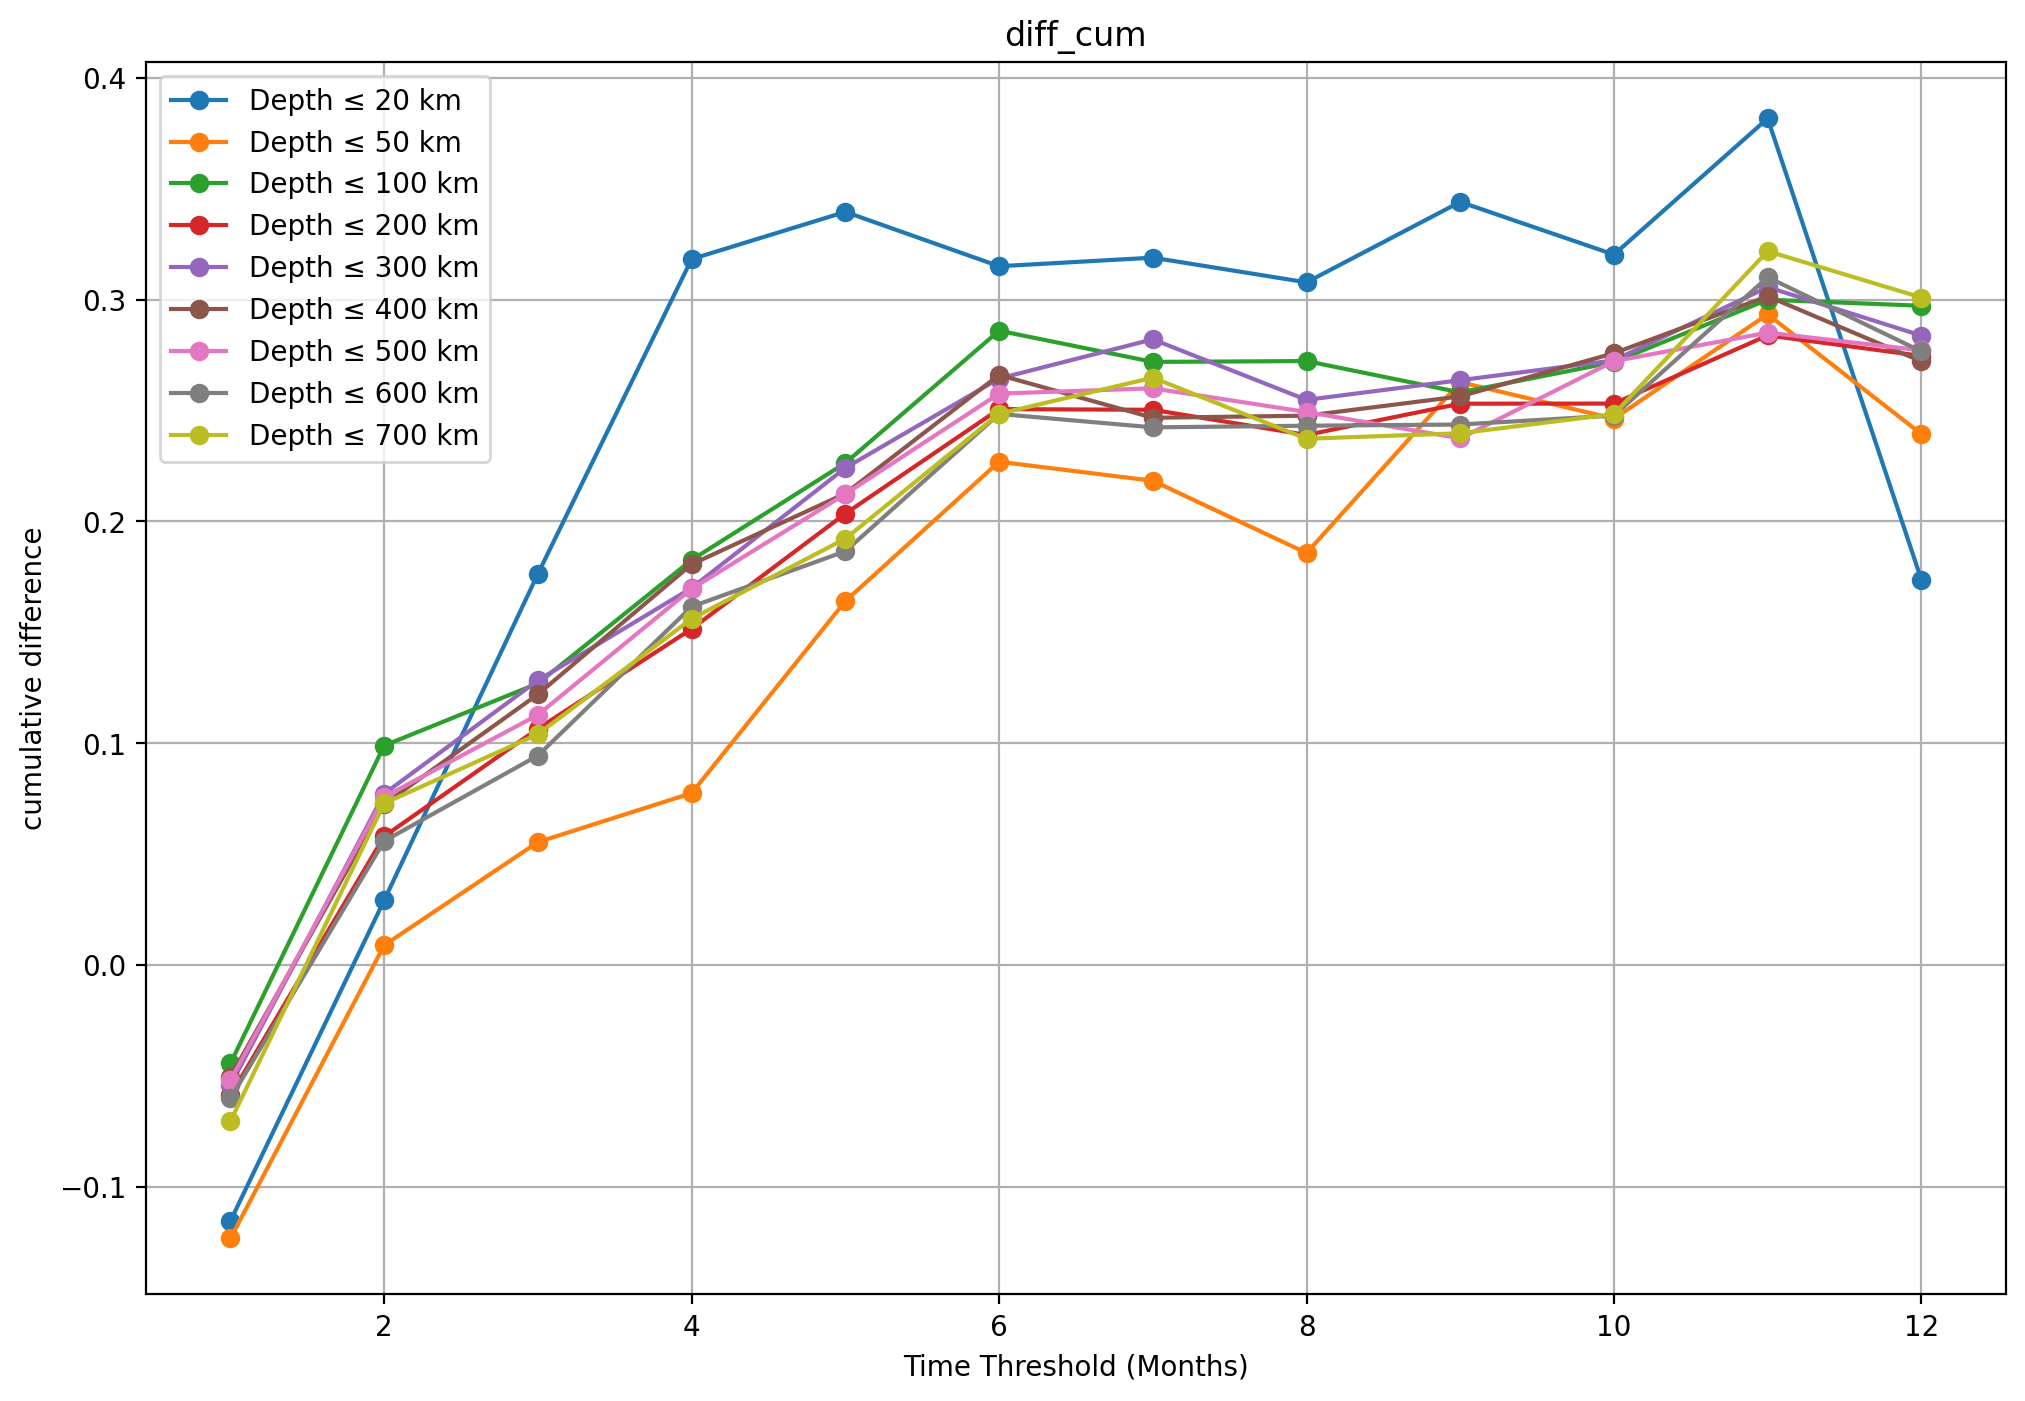

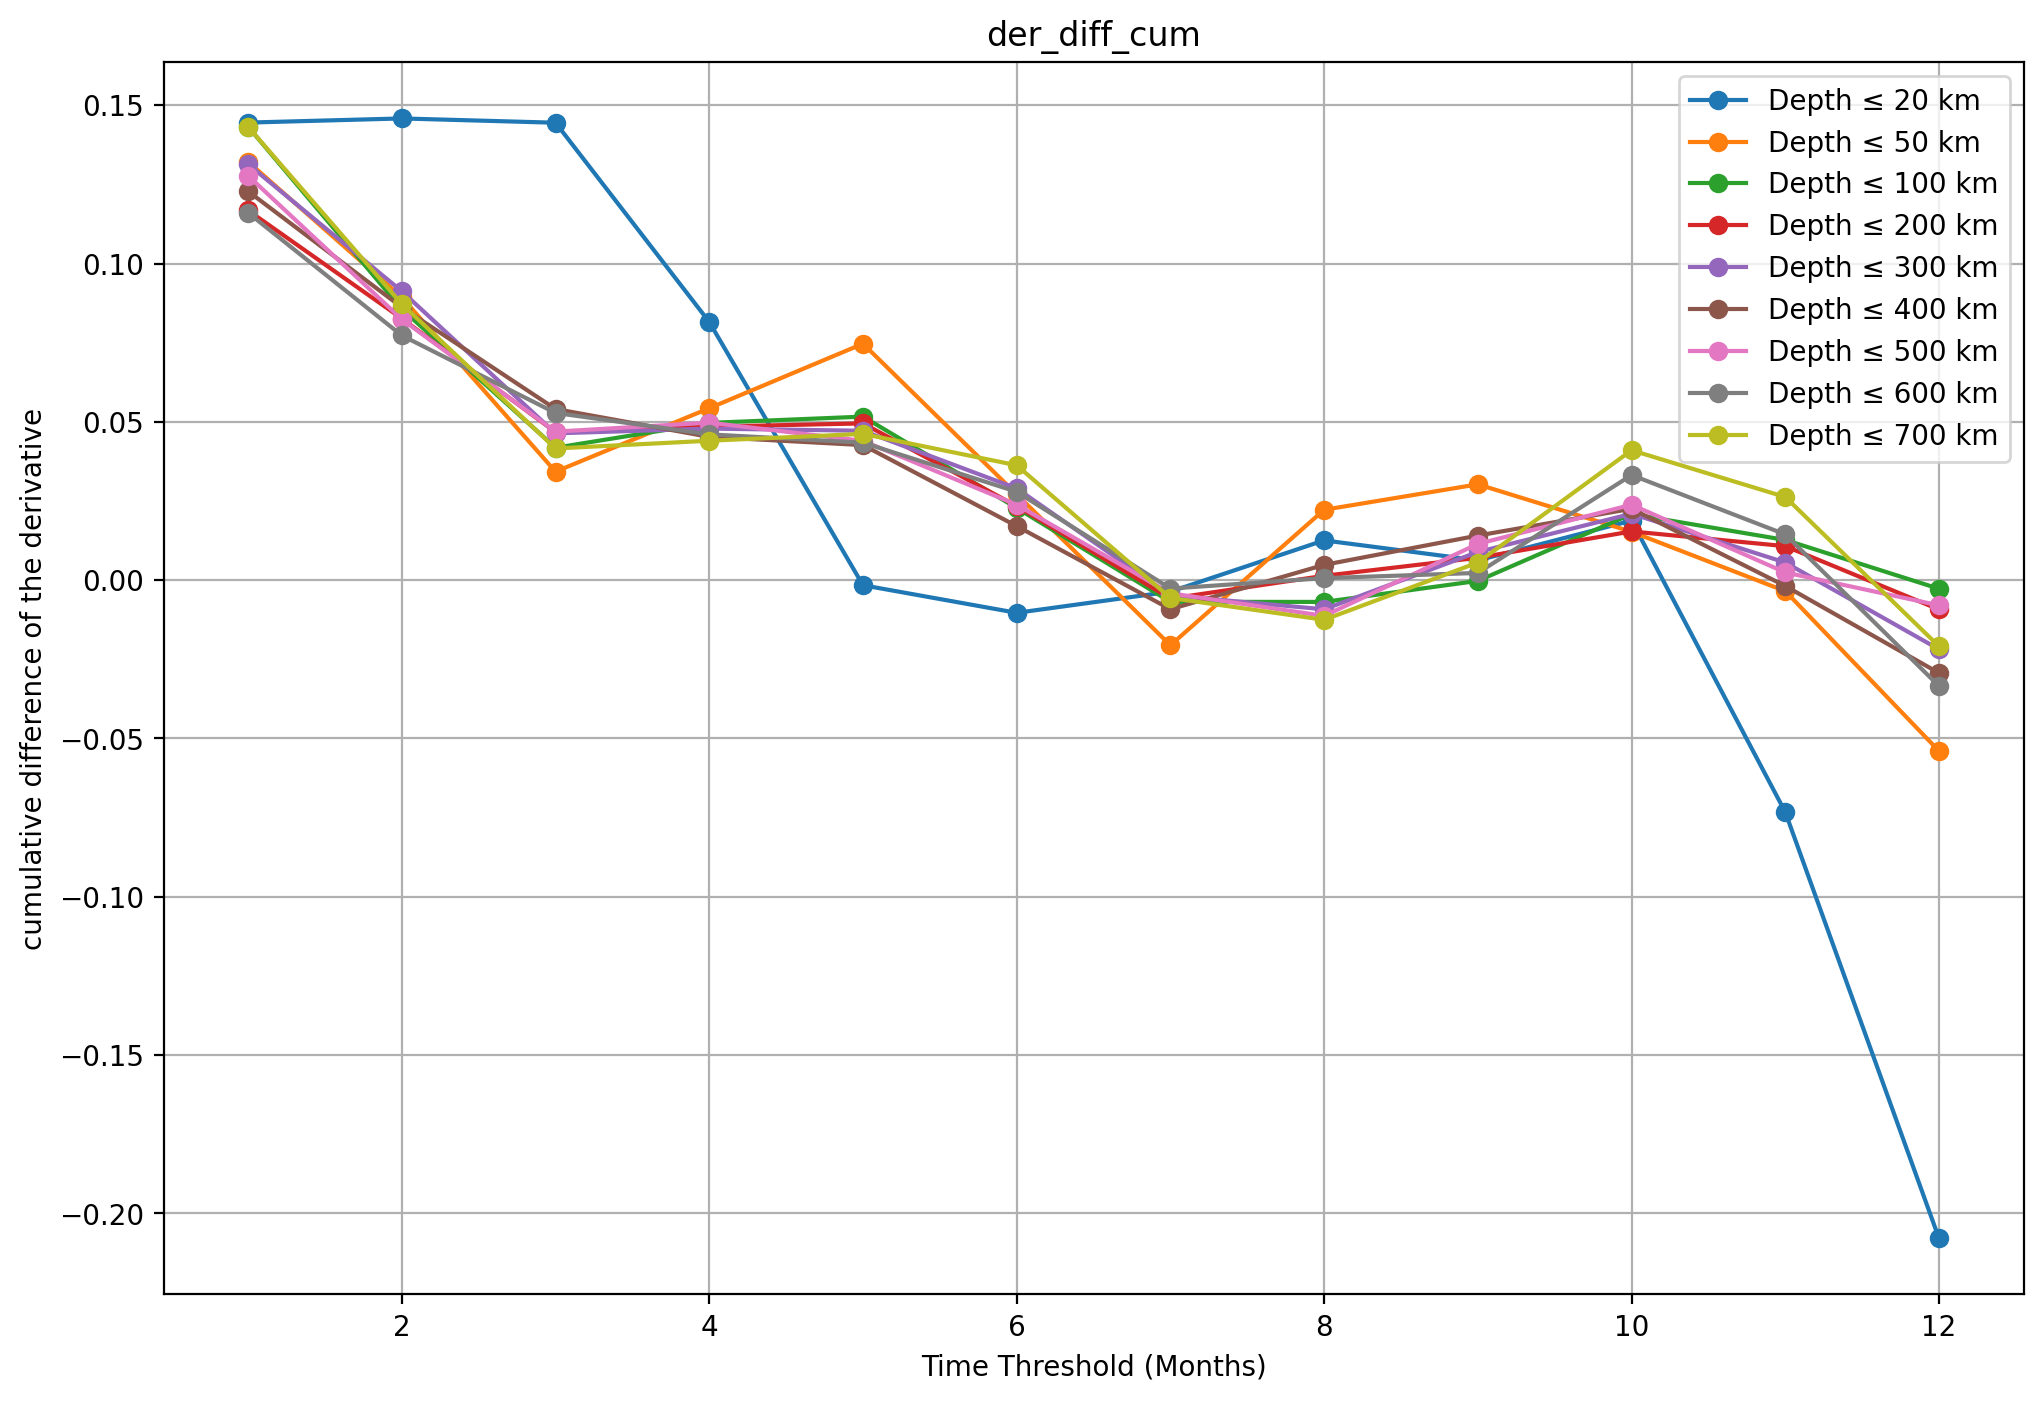

In [120]:
diff_cum = np.zeros((len(depth_values), len(time_thresholds_months)))

for i, depth in enumerate(depth_values):
    for j, t_month in enumerate(time_thresholds_months):
        t_seconds = t_month * 30.5 * 24 * 3600  # Convert months to seconds
        diff_cum[i, j] =  difference_matrix_java[i, j]-difference_matrix_SUM[i, j]
        
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, diff_cum[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

# plt.title('SUM-AND')
plt.title('diff_cum')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('cumulative difference')
plt.legend()
plt.grid(True)
plt.show()


der_diff_cum = np.zeros((len(depth_values), len(time_thresholds_months)))

for i, depth in enumerate(depth_values):
    for j, t_month in enumerate(time_thresholds_months):
        t_seconds = t_month * 30.5 * 24 * 3600  # Convert months to seconds
        der_diff_cum[i, j] =  derivative_matrix_java[i, j]-derivative_matrix_SUM[i, j]
        
plt.figure(figsize=(12, 8), dpi=200)

for i, depth in enumerate(depth_values):
    plt.plot(time_thresholds_months, der_diff_cum[i, :], marker='o', linestyle='-', label=f'Depth ≤ {depth} km')

# plt.title('SUM-AND')
plt.title('der_diff_cum')
plt.xlabel('Time Threshold (Months)')
plt.ylabel('cumulative difference of the derivative')
plt.legend()
plt.grid(True)
plt.show()